# **Efficient Frontier for Colombian Stocks**

# Install Packages

In [0]:
pip install investpy

In [0]:
pip install PyPortfolioOpt

# Imports

In [0]:
import investpy
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as scs
import statsmodels.api as sm
import scipy.optimize as sco
import scipy.interpolate as sci
from pandas_datareader import data as web
import warnings

warnings.filterwarnings('ignore')
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'sans-serif'

# Stock Data

In [0]:
# Select your stocks
symbols = ['ECO','BIC','ISA','SIS','ARG'] # Colombian Tickers from Investing.com
# symbols = ['MSFT','FB','TWTR','IBM','AAPL'] # Tickers from Yahoo Finance

#### From Investing.com

In [0]:
# Select Dates
from_date = '01/01/2014'
# to_date = datetime.today().strftime('%d/%m/%Y') # Today
to_date = '01/02/2020'

# Get all stocks in one DF
data= []
for i in symbols:
  data.append(investpy.get_stock_historical_data(stock=i,
                                                 country='colombia', from_date=from_date, to_date=to_date, interval='Daily'))

# Number of stocks = Number of Dataframes !!
dataf = [data[0], data[1], data[2], data[3], data[4]] 

# Concatenate all stocks data
df = pd.concat(objs=dataf,axis=1)
columns = [['Open_'+str(i) ,'High_'+str(i), 'Low_'+str(i), str(i), 'Volume_'+str(i) ,'Curreny_'+str(i)] for i in symbols]

# Convert columns list into a flat list 
col = [ii for i in columns for ii in i]

# Rename columns in DF
df.columns = col

# Select Price Column for each stock 
close_price = [i for i in symbols]
df = df[close_price]
df.tail(1)


,ECO,BIC,ISA,SIS,ARG
Date,,,,,
2020-01-31,3180.0,42440.0,18800.0,32000.0,17480.0


#### From Yahoo Finance

In [0]:
# Select Dates

# from_date = '2014-01-01'
# to_date = datetime.today().strftime('%Y-%m-%d')
# # to_date = '2019-12-01'

# df = pd.DataFrame()
# for i in symbols:
#   df[i] = web.DataReader(i,'yahoo',start=start, end=end)['Adj Close']

# df.tail(2)

# Plotting

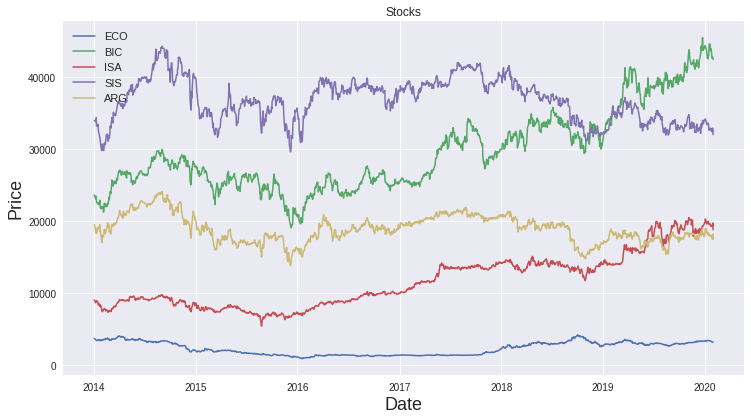

In [0]:
# Plotting Stock Prices
plt.figure(figsize=(12.2,6.5))

for i in df.columns.values:
  plt.plot(df[i], label =i, lw=1.5)

plt.title('Stocks')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Price', fontsize = 18)
plt.legend(df.columns.values,loc = 'upper left',fontsize = 11);

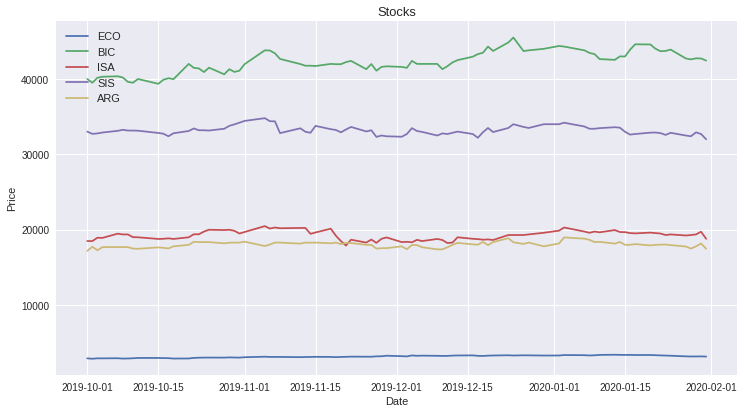

In [0]:
# Zoom in specific date
plt.figure(figsize=(12.2,6.5))
plt.plot(df.loc['2019-10-01':])
plt.title('Stocks',fontsize = 13)
plt.xlabel('Date', fontsize = 11)
plt.ylabel('Price', fontsize = 11)
plt.legend(df.columns.values,loc = 'upper left',fontsize = 11);

In [0]:
# Log Return
log_ret = np.log(df/df.shift(1))
log_ret.dropna(inplace=True)

# Simple Return
simple_ret = df.pct_change()
simple_ret.dropna(inplace=True)

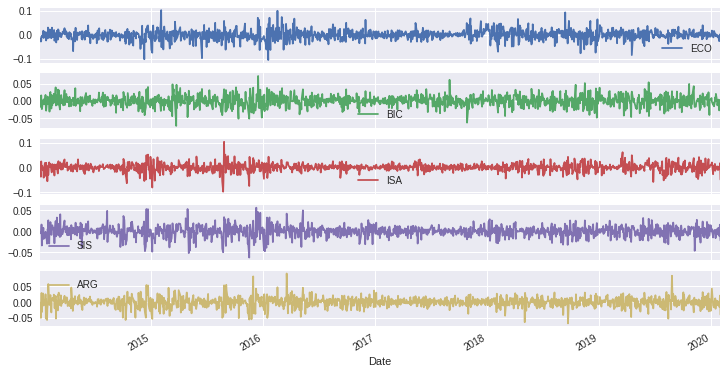

In [0]:
# Log Return All Stocks
log_ret.plot(subplots=True, figsize=(12.2,6.5));

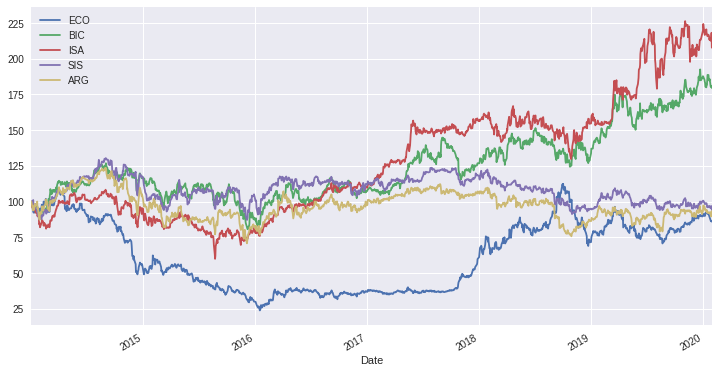

In [0]:
# Normed Return
(df/df.iloc[0]*100).plot(figsize=(12.2,6.5), lw=1.8);

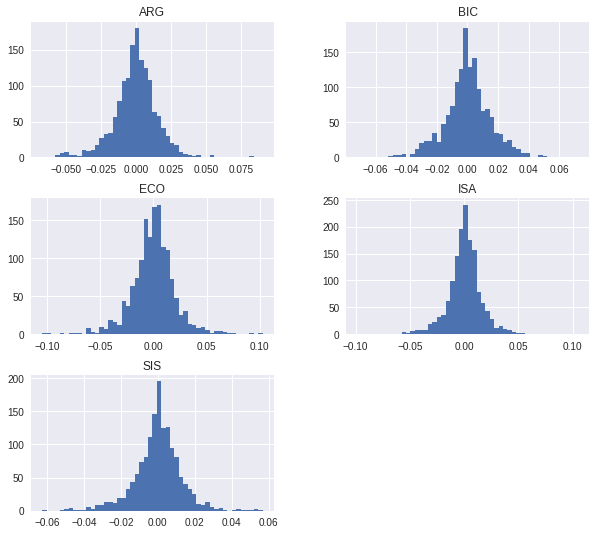

In [0]:
# Log Distribution
log_ret.hist(bins=50,figsize=(10,9));

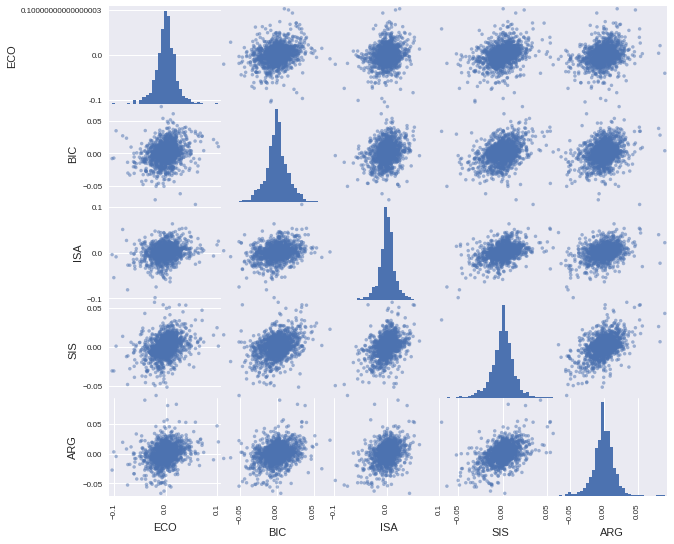

In [0]:
#Scatter Plot
pd.plotting.scatter_matrix(log_ret,  diagonal = 'hist', hist_kwds = {'bins':35}, figsize = (10,9));

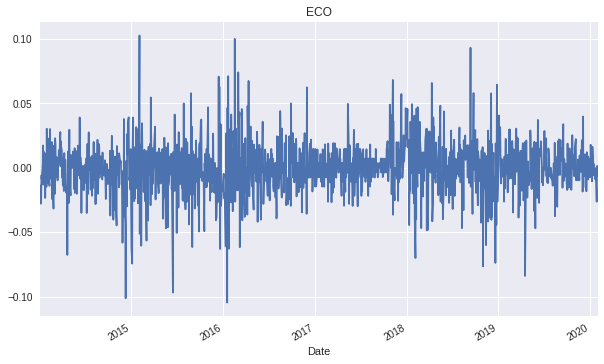

In [0]:
# Log Return per Stock 
s = 'ECO' # Select Stock

np.log(df[s]/df[s].shift(1)).plot(figsize=(10,6));
plt.title(s);

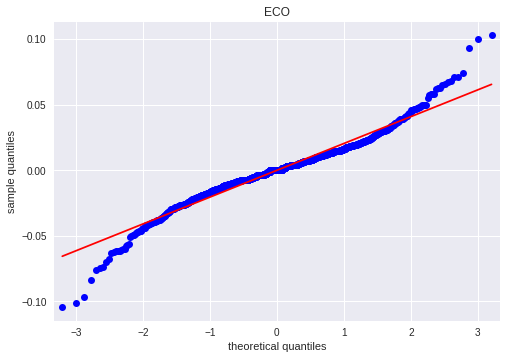

In [0]:
# QQ Plot
sm.qqplot(log_ret[s].dropna(),line='s',c='b')
plt.title(s) 
plt.xlabel('theoretical quantiles') 
plt.ylabel('sample quantiles');

Correlation between  SIS  and  ARG :  0.49302 



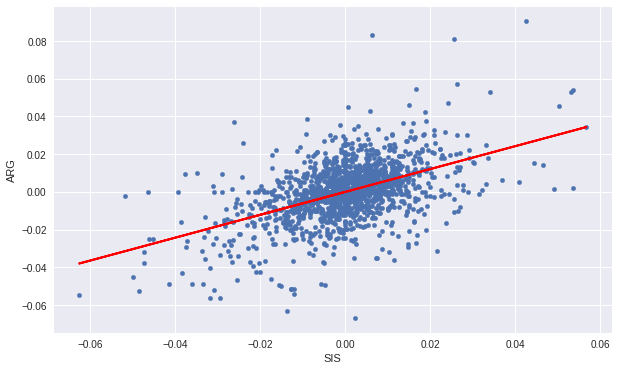

In [0]:
# Correlation: ordinary least-squares (OLS)
s = 'SIS' # Select stock
s2 = 'ARG' # Select stock

reg = np.polyfit(log_ret[s], log_ret[s2], deg = 1)
ax = log_ret.plot (kind = 'scatter', x =s, y = s2 , figsize =(10,6)) 

corr = round(log_ret[s].corr(log_ret[s2]),5)
print('Correlation between ',s,' and ',s2,': ',corr,'\n')
ax.plot(log_ret[s], np.polyval(reg, log_ret[s]), 'r', lw = 2);

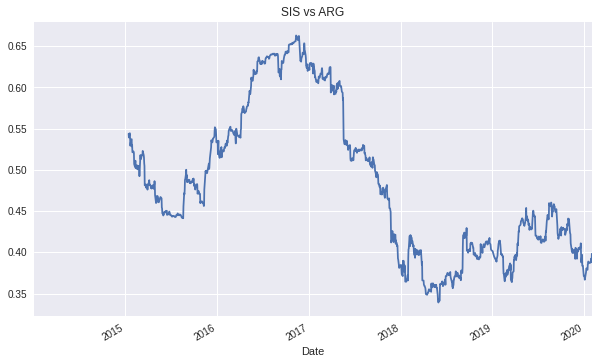

In [0]:
# Correlation over time
log_ret[s].rolling(window=252).corr(log_ret[s2]).plot(grid=True,figsize=(10,6));
plt.title(s +' vs '+ s2);

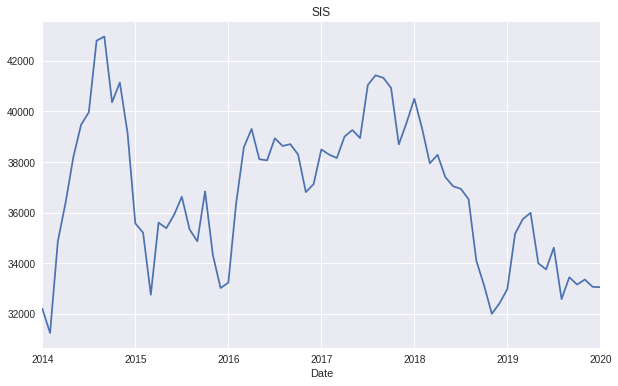

In [0]:
# Resample Data
df[s].resample('M').mean().plot(figsize=(10,6))
plt.title(s);

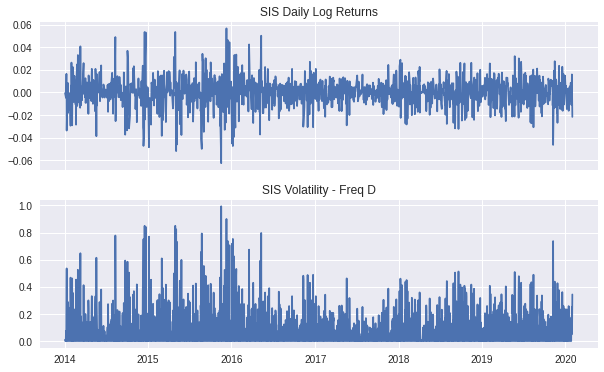

In [0]:
# Volatility Function
def realized_volatility(x):
  return np.sqrt(np.sum(x**2))

# Resample Data and Apply Function
freq= 'D'
n_days = 252
r_vol = log_ret.groupby(pd.Grouper(freq=freq)).apply(realized_volatility) # set frequency
r_vol = r_vol*np.sqrt(n_days) # change window

# Returns and Realized Volatility
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10,6))
ax[0].plot(log_ret[s])
ax[0].set(title = s +' Daily Log Returns')
ax[1].plot(r_vol[s])
ax[1].set(title = s+ ' Volatility - Freq '+ freq);

# Statistics

In [0]:
# Statistics
def print_statistics(a1):
  
  sta1 = scs.describe(a1)

  print('%14s %14s' % ('statistic','value')) 
  print(45*"-") 
  print('%14s %14.3f' % ('size',sta1[0])) 
  print('%14s %14.3f' % ('min',sta1[1][0])) 
  print('%14s %14.3f' % ('max',sta1[1][1]))
  print('%14s %14.3f' % ('mean',sta1[2]))  
  print('%14s %14.3f' % ('std',np.sqrt(sta1[3])))
  print('%14s %14.3f' % ('skew',sta1[4])) 
  print('%14s %14.3f' % ('kurtosis',sta1[5])) 

# Normatity Test
def normality_tests(arr):

    print("Skew of data set  %14.3f" % scs.skew(arr))
    print("Skew test p-value %14.3f" % scs.skewtest(arr)[1])
    print("Kurt of data set  %14.3f" % scs.kurtosis(arr))
    print("Kurt test p-value %14.3f" % scs.kurtosistest(arr)[1])
    print("Norm test p-value %14.3f" % scs.normaltest(arr)[1])

In [0]:
for i in symbols:
  print('\nResults for symbol {}'.format(i))
  print(30*'-')
  log_data = np.array(log_ret[i].dropna())
  print_statistics(log_data)


Results for symbol ECO
------------------------------
     statistic          value
---------------------------------------------
          size       1481.000
           min         -0.104
           max          0.103
          mean         -0.000
           std          0.020
          skew         -0.097
      kurtosis          3.276

Results for symbol BIC
------------------------------
     statistic          value
---------------------------------------------
          size       1481.000
           min         -0.072
           max          0.072
          mean          0.000
           std          0.015
          skew         -0.049
      kurtosis          1.529

Results for symbol ISA
------------------------------
     statistic          value
---------------------------------------------
          size       1481.000
           min         -0.098
           max          0.105
          mean          0.000
           std          0.016
          skew         -0.299
      k

In [0]:
for i in symbols:
    print("\nResults for symbol %s" % i)
    print(30 * "-")
    log_data = np.array(log_ret[i].dropna())
    normality_tests(log_data)


Results for symbol ECO
------------------------------
Skew of data set          -0.097
Skew test p-value          0.126
Kurt of data set           3.276
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol BIC
------------------------------
Skew of data set          -0.049
Skew test p-value          0.443
Kurt of data set           1.529
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol ISA
------------------------------
Skew of data set          -0.299
Skew test p-value          0.000
Kurt of data set           4.220
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol SIS
------------------------------
Skew of data set          -0.200
Skew test p-value          0.002
Kurt of data set           2.648
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol ARG
------------------------------
Skew of data set          -0.063
Skew test p-value          0.321

# Portfolio Optimization

#### Monte Carlo Simulation of Portfolio Weights

In [0]:
# Simple Return
returns_annual = simple_ret.mean() * n_days

# covariance
cov_daily = simple_ret.cov()
cov_annual = cov_daily * n_days

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# number of combinations for imaginary portfolios
num_stocks = len(symbols)
num_portfolios = 100000

# set random seed for reproduction
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):

    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility # riskfree = 0
    sharpe_ratio.append(sharpe) 
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each stock and weight in the portfolio
for counter,symbol in enumerate(symbols):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

portfolio.keys()

dict_keys(['Returns', 'Volatility', 'Sharpe Ratio', 'ECO Weight', 'BIC Weight', 'ISA Weight', 'SIS Weight', 'ARG Weight'])

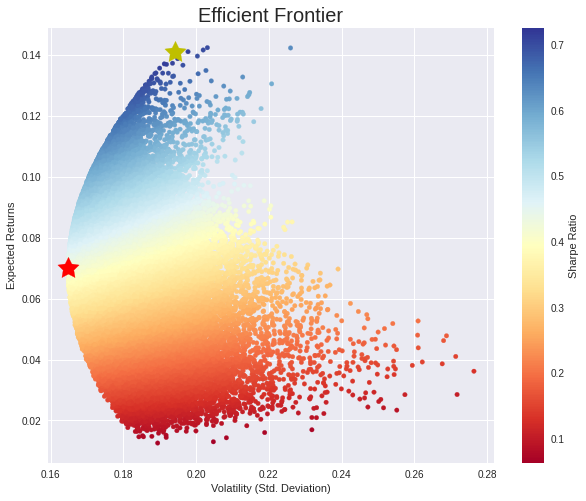

In [0]:
# make a nice dataframe of the extended dictionary
dfm = pd.DataFrame(portfolio)

# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = dfm['Volatility'].min()
max_sharpe = dfm['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = dfm.loc[dfm['Sharpe Ratio'] == max_sharpe]
min_variance_port = dfm.loc[dfm['Volatility'] == min_volatility]

# plotting frontier
fig,ax1=plt.subplots()
dfm.plot.scatter('Volatility', 'Returns', c='Sharpe Ratio', 
                cmap='RdYlBu', figsize=(10, 8), grid=True,ax=ax1)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], marker=(5,1,0), c='y',s=500)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], marker=(5,1,0), c='r', s=500 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier',fontsize=20)
plt.show()

In [0]:
print('Minimun Variance Portfolio:\n')
print(min_variance_port.T,'\n')
print('Maximum sharpe Portfolio:\n')
print(sharpe_portfolio.T)

Minimun Variance Portfolio:

                 88795
Returns       0.069986
Volatility    0.164826
Sharpe Ratio  0.424605
ECO Weight    0.078844
BIC Weight    0.240285
ISA Weight    0.204278
SIS Weight    0.348250
ARG Weight    0.128342 

Maximum sharpe Portfolio:

                 19621
Returns       0.140984
Volatility    0.194283
Sharpe Ratio  0.725665
ECO Weight    0.020040
BIC Weight    0.410700
ISA Weight    0.561843
SIS Weight    0.006014
ARG Weight    0.001402


#### Optimization Problem

In [0]:
# Functions for Portfolio Calculations
def statistics(weights):
    ''' Sharpe ratio for riskfree = 0
    '''
    weights = np.array(weights)
    p_rets = np.sum(simple_ret.mean() * weights) * n_days
    p_volt = np.sqrt(np.dot(weights.T, np.dot(simple_ret.cov() * n_days, weights)))
    return np.array([p_rets, p_volt, p_rets / p_volt])

In [0]:
# Functions to Minimize
def min_func_sharpe(weights):
    return -statistics(weights)[2]

def min_func_variance(weights):
    return statistics(weights)[1]

In [0]:
# Constraints
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) # No Short positions

# Boundaries
bnds = tuple((0, 1) for x in range(num_stocks))

# Equal Weights
equal_weights = num_stocks*[1./num_stocks]

In [0]:
# Maximization of Sharpe Ratio 
opts = sco.minimize(min_func_sharpe, equal_weights, method='SLSQP',
                       bounds=bnds, constraints=cons)
opts

     fun: -0.7331831486587128
     jac: array([ 2.17635766e-01,  1.30981207e-05, -1.05202198e-05,  3.06816317e-01,
        3.15576300e-01])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.        , 0.44538477, 0.55461523, 0.        , 0.        ])

In [0]:
# Optimal weights that maximizes the sharpe ratio
pd.DataFrame([round(x,4) for x in opts['x']],index=symbols).T

,ECO,BIC,ISA,SIS,ARG
0,0.0,0.4454,0.5546,0.0,0.0


In [0]:
# Optimal Portfolio Metrics [Annual Return, Annual Volatility, Sharpe Ratio]
statistics(opts['x']).round(5)

array([0.1437 , 0.196  , 0.73318])

In [0]:
# Minimun Variance Portfolio
optv = sco.minimize(min_func_variance, equal_weights, method='SLSQP',
                       bounds=bnds, constraints=cons)
optv

     fun: 0.1647870086004502
     jac: array([0.16486409, 0.16482999, 0.16479008, 0.16479395, 0.16463936])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.0856964 , 0.24429023, 0.19384942, 0.34029119, 0.13587276])

In [0]:
# Optimal Weights in Minumum Variance Portfolio
pd.DataFrame([round(x,2) for x in optv['x']],index=symbols).T

,ECO,BIC,ISA,SIS,ARG
0,0.09,0.24,0.19,0.34,0.14


In [0]:
# Minimum Variance Porfolio Metrics [Annual Return, Annual Volatility, Sharpe Ratio]
statistics(optv['x']).round(5)

array([0.06907, 0.16479, 0.41915])

In [0]:
# Eficient Frontier Calculations

cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - i},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

bnds = tuple((0, 1) for x in weights)

target_ret = np.linspace(0.02, 0.142, 50)
target_vol = []

for i in target_ret:
    res = sco.minimize(min_func_variance, equal_weights, method='SLSQP',
                       bounds=bnds, constraints=cons)
    target_vol.append(res['fun'])

target_vol = np.array(target_vol)

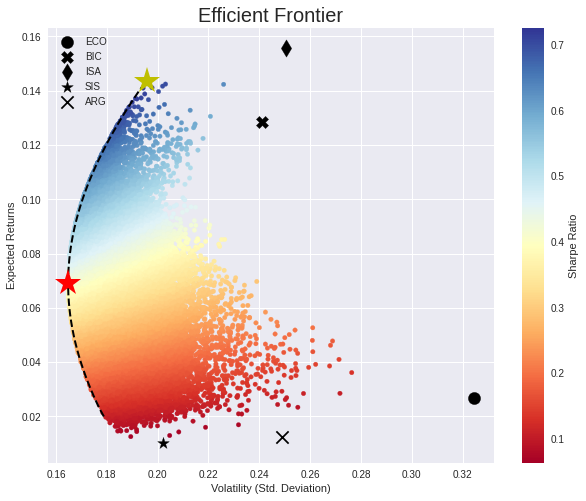

In [0]:
# Plotting frontier
fig,ax1=plt.subplots()
# Random Portfolio Composition
dfm.plot.scatter('Volatility', 'Returns', c='Sharpe Ratio', 
                cmap='RdYlBu', figsize=(10, 8), grid=True,ax=ax1)
# Eficient Frontier
plt.plot(target_vol, target_ret, c='black', lw=2, linestyle='--')
# portfolio with highest Sharpe ratio
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize=28, c='y')    
# minimum variance portfolio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=28, c='r')

# Plot Stocks
MARKS = ['o', 'X', 'd', '*','x']

for i in range(num_stocks):
  plt.scatter(x=np.sqrt(cov_annual.iloc[i, i]),y=returns_annual[i],marker=MARKS[i],
             s=150, color='black', label=symbols[i])
plt.legend(loc = 'upper left')

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier',fontsize=20)
plt.show()

# PyPortfolioOpt Library

#### [Documentation](https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html)

In [0]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Portfolio Optimization

mu = expected_returns.mean_historical_return(df)
s = risk_models.sample_cov(df)

# Optimize for max Sharpe Ratio

ef = EfficientFrontier(mu,s)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights,'\n')

# Riskfree = 0
ef.portfolio_performance(verbose=True,risk_free_rate=0)

{'ECO': 0.0, 'BIC': 0.43204, 'ISA': 0.56796, 'SIS': 0.0, 'ARG': 0.0} 

Expected annual return: 14.4%
Annual volatility: 19.7%
Sharpe Ratio: 0.73


(0.14406456150209906, 0.19653202475586729, 0.7330335179778285)

In [0]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

total_position = 10000000

# Take the last price of stocks
latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = total_position)

allocation, leftover = da.lp_portfolio()
print("Discrete Allocation:", allocation)
print('Funds Remaining: ${:.2f}'.format(leftover))

Discrete Allocation: {'BIC': 102.0, 'ISA': 301.0}
Funds Remaining: $12320.00
